#Import Libraries and mount drive

In [0]:
import numpy as np
import torch 
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cv2
import os
import torchvision
import torch.nn as nn
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Debugging - Data preprocessing

In [0]:
df=pd.read_csv("labels.csv")

In [0]:
df.drop(['Preview URL'], inplace=True, axis=1)

In [0]:
df=df.loc[df['Label']=='Car']
df=df.reset_index()
df.drop(['index'], inplace=True, axis=1)

In [0]:
df['x']=df['xmax']
df['xmax']=df['ymin']
df['ymin']=df['x']

In [0]:
df['x']=(df.xmax+df.xmin)/2
df['y']=(df.ymax+df.ymin)/2
df['h']=(df.ymax-df.ymin)
df['w']=(df.xmax-df.xmin)

In [0]:
df.drop(['xmin','xmax', 'ymin', 'ymax', 'Label'], axis=1, inplace=True)

In [0]:
# df

#Data preprocessing complete

#Debugging - Visualising the data

In [0]:
df2=pd.read_csv("labels.csv")

In [0]:
df2.drop(['Preview URL'], inplace=True, axis=1)

In [0]:
df2=df2.loc[df2['Label']=='Car']
df2=df2.reset_index()
df2.drop(['index'], inplace=True, axis=1)

In [0]:
import cv2
import matplotlib.pyplot as plt


0 554 112 698
109 559 241 676
550 582 595 607
600 580 637 603
684 546 820 671
1778 553 1919 693


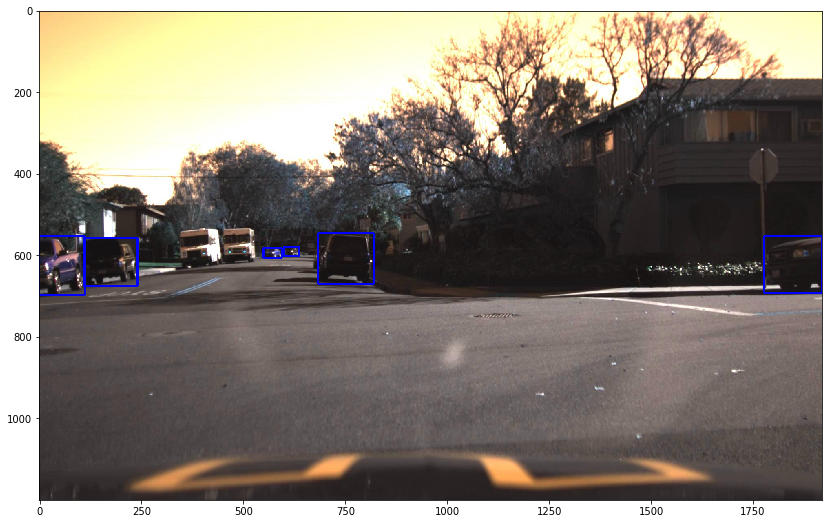

In [0]:
img='1479498373462797835.jpg'
df3=df2.loc[df2['Frame']==img]
image=cv2.imread(img)
for index, row in df3.iterrows():
  print(row.xmin, row.xmax, row.ymin, row.ymax)
  # print(row)
  image = cv2.rectangle(image, ((int(row.xmin), int(row.xmax))), (int(row.ymin), int(row.ymax)), (0, 0, 255), 3)

plt.figure(figsize=(15,9))
plt.imshow(image)

In [0]:
image.shape

(1200, 1920, 3)

In [0]:
# df3

#Data visualisation complete

,xmin,xmax,ymin,ymax,Frame,Label
25,0,554,112,698,1479498373462797835.jpg,Car
26,109,559,241,676,1479498373462797835.jpg,Car
27,550,582,595,607,1479498373462797835.jpg,Car
28,600,580,637,603,1479498373462797835.jpg,Car
29,684,546,820,671,1479498373462797835.jpg,Car
30,1778,553,1919,693,1479498373462797835.jpg,Car


#Debugging - IoU

In [0]:
class iou:  
  #takes the end points of both the windows as input while making the object

  def __init__(self, yleft1, xupper1, yright1, xlower1, yleft2, xupper2, yright2, xlower2):
    if(yleft1>yright1) or (yleft2>yright2) or (xupper1>xlower1) or (xupper2>xlower2):
      print("Bad inputs for comparison \n")
    self.yleft=max(yleft1, yleft2)
    self.yright=min(yright1, yright2)
    self.xupper=max(xupper1, xupper2)
    self.xlower=min(xlower1, xlower2)
    self.width=max(0,self.yright-self.yleft)
    self.height=max(0,self.xlower-self.xupper)
    self.union=(yright1-yleft1)*(xlower1-xupper1)+(yright2-yleft2)*(xlower2-xupper2) - self.width*self.height
    self.intersection = self.width*self.height

  def get_error(self):    #call this function to get the actual output
    return max(0, self.intersection/self.union)

In [0]:
myobj = iou(1, 2, 3, 6, 1, 2, 5, 6)
print(myobj.get_error())

0.5


#Debugging - Finding out Anchors


In [0]:
class anchors:

  def ioudim(self,box, clusters):
    if(len(list(clusters.shape))  == 1):
        x = np.minimum(clusters[0], box[0])
        y = np.minimum(clusters[1], box[1])
        cluster_area = clusters[0] * clusters[1]
    else:    
        x = np.minimum(clusters[:, 0], box[0])
        y = np.minimum(clusters[:, 1], box[1])
        cluster_area = clusters[:, 0] * clusters[:, 1]
    intersection = x * y
    box_area = box[0] * box[1]
   

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

  def __init__(self, labels):
    #takes the proposed labels(width, height)
    # In the format of N*2 numpy array
    self.boxes = labels
    # for i in range(5000):
    #   self.boxes.loc[i]= [np.random(0, imagewidth), np.random(0, imageheight)]
    # np.random.seed()
    # self.labels = labels
    # self.kmin = krangemin
    # self.kmax = krangemax
  
  def kmeans(self, k):
    rows = self.boxes.shape[0]
    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))
    # t = int( time.time() * 1000.0 )
    # np.random.seed( ((t & 0xff000000) >> 24) + ((t & 0x00ff0000) >>  8) + ((t & 0x0000ff00) <<  8) + ((t & 0x000000ff) << 24))
    # np.random.seed(int(time.time()))

    clusters = self.boxes[np.random.choice(rows, k, replace= False)]

    # print("Initial Cluters : ", clusters)
    for i in range(100):
      for row in range(rows):
        distances[row]=1 - self.ioudim(self.boxes[row], clusters)

      nearest_clusters = np.argmin(distances, axis=1)

      if (nearest_clusters == last_clusters).all():
        break;

      for cluster in range(k):
            clusters[cluster] = np.mean(self.boxes[nearest_clusters == cluster], axis=0)

      last_clusters = nearest_clusters

    distance = 0

    for i in range(rows):
      distance += (self.ioudim(self.boxes[i], clusters[nearest_clusters[i]]).reshape(1,-1)).sum()

    return clusters, distance
      


  def learn(self, kmin, kmax):

    #takes kmin and kmax as input
    k_val = []
    avg_iou = []
    for i in range(kmin, kmax+1):                                                                                                                                                                                                                                                                      
      iou = 0
      for j in range(8):
        clusters1, iou1 = self.kmeans(i)
        if iou1>iou:
          iou=iou1
          clusters=clusters1

      k_val.append(i)
      avg_iou.append(iou/self.boxes.shape[0]);

      print('for k = ', i, "avg_iou = ", iou/self.boxes.shape[0])
    return k_val , avg_iou, clusters
    

In [0]:
a = anchors(data)

In [0]:
k_val, avg_iou, cluster_points = a.learn(2,8)

#Debugging - Loss Function

In [0]:
import torch

def loss(target, prediction):
  #need 
  #prediction is a numpy array of the dimensions - BatchSize*NoOfAnchors*GridSize*GridSize*5
  #target is a numpy array of the dimensions - batchsize*NoOfAnchors*GridSize*GridSize*5
  
  #order of anchor parameters in prediction are confidence, horizontal, vertical, width, height
  #order of anchor parameters in target are confidence, horizontal, vertical, width, height

  # batchsize = target.shape[0]
  # gridsize = target.shape[2]

  # no_of_anchors = target.shape[1]

  localisation_error = 0
  detection_error = 0

  lambda_bigger = 5
  lambda_smaller = 0.5

  # maxanchor = torch.zeros((batchsize, gridsize, gridsize))

  # mask = torch.zeros((batchsize, gridsize, gridsize, no_of_anchors))
  # revmask = torch.ones((batchsize, gridsize, gridsize, no_of_anchors))

  # for b in range(batchsize):
  #   for g1 in range(gridsize):
  #     for g2 in range(gridsize):
  #       temp = maxanchor[b, g1, g2] = torch.argmax(target[b, g1, g2, :, 0])
  #       mask[b, g1, g2, temp] = 1
  #       revmask[b, g1, g2, temp] = 0
        
        # for a in no_of_anchors:

          # target[b, g1, g2, a, 1] = sigmoid(target[b, g1, g2, a, 1]) + g1*span
          # prediction[b, g1, g2, a, 1] = sigmoid(prediction[b, g1, g2, a, 1]) +g1*span

          # target[b, g1, g2, a, 2] = sigmoid(target[b, g1, g2, a, 2]) + g2*span
          # prediction[b, g1, g2, a, 2] = sigmoid(prediction[b, g1, g2, a, 2]) +g2*span

          # target[b, g1, g2, a, 3] = np.exp(target[b, g1, g2, a, 3])*(anchor[maxanchor[b,g1,g2], 0])
          # prediction[b, g1, g2, a, 3] = np.exp(prediction[b, g1, g2, a, 3])*(anchor[maxanchor[b,g1,g2], 0])
          
          # target[b, g1, g2, a, 4] = np.exp(target[b, g1, g2, a, 4])*(anchor[maxanchor[b,g1,g2], 1])
          # prediction[b, g1, g2, a, 4] = np.exp(prediction[b, g1, g2, a, 4])*(anchor[maxanchor[b,g1,g2], 1])

  mask = (target[:, :, :, :, 0] == 1)
  revmask = ~mask

  error_x = ((((target[:, :, :, :, 1] - prediction[:, :, :, :, 1])**2)[mask]).sum())
  error_y = ((((target[:, :, :, :, 2] - prediction[:, :, :, :, 2])**2)[mask]).sum())

  error_w = (((((target[:, :, :, :, 3]) - (prediction[:, :, :, :, 3]))**2)[mask]).sum())
  error_h = (((((target[:, :, :, :, 4]) - (prediction[:, :, :, :, 4]))**2)[mask]).sum())

  localisation_error = lambda_bigger * (error_x + error_y + error_w + error_h)

  correct_pred_error = (((target[:, :, :, :, 0] - prediction[:, :, :, :, 0])**2)[mask]).sum()
  incorrect_pred_error = (((target[:, :, :, :, 0] - prediction[:, :, :, :, 0])**2)[revmask]).sum()

  detection_error = correct_pred_error + lambda_smaller * incorrect_pred_error

  total_error = detection_error + localisation_error

  return total_error/target.shape[0]

In [0]:
target = torch.tensor([[[[[1., 3., 3., 4., 5.],[0., 6., 7., 8., 9.]]]], [[[[1., 3., 3., 4., 5.],[0., 6., 7., 8., 9.]]]]])
prediction = torch.tensor([[[[[0.6, 2., 3., 4., 5.],[0.4, 6., 7., 8., 9.]]]], [[[[0.6, 2., 3., 4., 5.],[0.4, 6., 7., 8., 9.]]]]])
loss(target, prediction)

tensor(5.2400)

In [0]:
temp = target[:, :, :, :, 0]==1
print(target[:, :, :, :, 1][temp])
print(prediction[:, :, :, :, 1][temp])

tensor([3., 3.])
tensor([2., 3.])


#Debugging - How np.argmax works:

In [0]:
import numpy as np
arr = np.random.randint(16, size = (3,3))
arr

array([[15,  4,  3],
       [ 9,  6,  8],
       [ 5, 13,  6]])

In [0]:
mask=np.random.randint(2, size=(3,3))
mask

array([[1, 1, 1],
       [1, 1, 1],
       [0, 0, 0]])

In [0]:
mask*arr

array([[15,  4,  3],
       [ 9,  6,  8],
       [ 0,  0,  0]])

In [0]:
np.argmin(arr, axis = 0)

array([[2, 0, 2],
       [2, 0, 2],
       [1, 1, 0]])

In [0]:
np.argmin(arr, axis = 1)

array([[2, 0, 2],
       [2, 2, 2],
       [0, 2, 0]])

In [0]:
arr[0, :, :]


array([[13,  3, 13],
       [13,  3,  8],
       [12, 12,  2]])

In [0]:
arr[:,:,0]

array([[13, 13, 12],
       [13,  9,  6],
       [ 4,  5, 10]])

In [0]:
np.argmin(arr[:][:][0], axis = 1)

array([1, 1, 2])

In [0]:
arr.shape

(3, 3, 3)

In [0]:
np.square(arr)

array([[[169,   9, 169],
        [169,   9,  64],
        [144, 144,   4]],

       [[169,  64,  36],
        [ 81,  16,  81],
        [ 36,   0,  25]],

       [[ 16,  81,  25],
        [ 25, 169,  36],
        [100,   9,  25]]])

In [0]:
arr.sum()

199

#File Paths

In [0]:
path = "drive/My Drive/Detect_karlo/object-detection-crowdai/labels.csv"
anchors_path  = "drive/My Drive/Detect_karlo/values/anchors.npy"
images_path = "drive/My Drive/Detect_karlo/object-detection-crowdai"
image_array_path = "drive/My Drive/Detect_karlo/values/images.npy"
models_path = "drive/My Drive/Detect_karlo/models"
folder_path = "drive/My Drive/Detect_karlo/result"

#IouFinder

In [0]:
def IOU_finder(box , boxes):
    """
        This function takes as input the boxes with (center_hor , center_ver , width , height)
        Input is numpy array
    """
    hor1_box = box[:,0] - box[:,2]/2
    hor2_box = box[:,0] + box[:,2]/2
    ver1_box = box[:,1] - box[:,3]/2
    ver2_box = box[:,1] + box[:,3]/2

    hor1_boxes = boxes[:,0] - boxes[:,2]/2
    hor2_boxes = boxes[:,0] + boxes[:,2]/2
    ver1_boxes = boxes[:,1] - boxes[:,3]/2
    ver2_boxes = boxes[:,1] + boxes[:,3]/2

    hor1_inter = np.maximum(hor1_box , hor1_boxes)
    ver1_inter = np.maximum(ver1_box , ver1_boxes)

    hor2_inter = np.minimum(hor2_box , hor2_boxes)
    ver2_inter = np.minimum(ver2_box , ver2_boxes)

    intersection = np.clip(hor2_inter - hor1_inter , a_min = 0, a_max = np.inf)*np.clip(ver2_inter - ver1_inter , a_min = 0, a_max = np.inf)
    union = np.clip(hor2_box - hor1_box , a_min = 0, a_max = np.inf)*np.clip(ver2_box - ver1_box , a_min = 0, a_max = np.inf) + np.clip(hor2_boxes - hor1_boxes , a_min = 0, a_max = np.inf)*np.clip(ver2_boxes - ver1_boxes , a_min = 0, a_max = np.inf)
    union -= intersection + 1e-16
   # union = np.clip(hor2_inter - hor1_inter + 1 , a_min = 0)*np.clip(ver2_inter - ver1_inter , a_min = 0) 
    return intersection/union





def ioufinder(box , boxes):
    """
        This function takes as input the boxes with (center_hor , center_ver , width , height)
        Input is numpy array
    """
    hor1_box = box[0] - box[:,2]/2
    hor2_box = box[0] + box[:,2]/2
    ver1_box = box[1] - box[:,3]/2
    ver2_box = box[1] + box[:,3]/2

    hor1_boxes = boxes[0] - boxes[:,2]/2
    hor2_boxes = boxes[0] + boxes[:,2]/2
    ver1_boxes = boxes[1] - boxes[:,3]/2
    ver2_boxes = boxes[1] + boxes[:,3]/2

    hor1_inter = np.maximum(hor1_box , hor1_boxes)
    ver1_inter = np.maximum(ver1_box , ver1_boxes)

    hor2_inter = np.minimum(hor2_box , hor2_boxes)
    ver2_inter = np.minimum(ver2_box , ver2_boxes)

    intersection = np.clip(hor2_inter - hor1_inter , a_min = 0, a_max = np.inf)*np.clip(ver2_inter - ver1_inter , a_min = 0, a_max = np.inf)
    union = np.clip(hor2_box - hor1_box , a_min = 0, a_max = np.inf)*np.clip(ver2_box - ver1_box , a_min = 0, a_max = np.inf) + np.clip(hor2_boxes - hor1_boxes , a_min = 0, a_max = np.inf)*np.clip(ver2_boxes - ver1_boxes , a_min = 0, a_max = np.inf)
    union -= intersection + 1e-16
   # union = np.clip(hor2_inter - hor1_inter + 1 , a_min = 0)*np.clip(ver2_inter - ver1_inter , a_min = 0) 
    return intersection/union









#Anchors

In [0]:
class Anchors:
    def ioudim(self,box, clusters):
        if(len(list(clusters.shape))  == 1):
            x = np.minimum(clusters[0], box[0])
            y = np.minimum(clusters[1], box[1])
            cluster_area = clusters[0] * clusters[1]
        else:    
            x = np.minimum(clusters[:, 0], box[0])
            y = np.minimum(clusters[:, 1], box[1])
            cluster_area = clusters[:, 0] * clusters[:, 1]
        intersection = x * y
        box_area = box[0] * box[1]
    

        iou_ = intersection / (box_area + cluster_area - intersection)

        return iou_

    def __init__(self, csv_path, orignal_dim = (1200,1920)):
        #takes the proposed labels(width, height)
        # In the format of N*2 numpy array
        self.orignal_dim = orignal_dim
        self.scale = 1/max(self.orignal_dim)
        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)
        self.boxes = self. kmeans_anchors_data()
        # for i in range(5000):
        #   self.boxes.loc[i]= [np.random(0, imagewidth), np.random(0, imageheight)]
        # np.random.seed()
        # self.labels = labels
        # self.kmin = krangemin
        # self.kmax = krangemax

    def kmeans_anchors_data(self):
        lst = []
        for xmin ,xmax,ymin,ymax in zip(self.data["xmin"], self.data["xmax"],self.data["ymin"], self.data["ymax"]):
            hor_min = xmin*self.scale
            ver_min = xmax*self.scale
            hor_max = ymin*self.scale
            ver_max = ymax*self.scale
            
            width = (hor_max - hor_min)
            height = (ver_max - ver_min)


            lst.append([width,height])
        return np.array(lst)

    
    def kmeans(self, k):
        rows = self.boxes.shape[0]
        distances = np.empty((rows, k))
        last_clusters = np.zeros((rows,))
        # t = int( time.time() * 1000.0 )
        # np.random.seed( ((t & 0xff000000) >> 24) + ((t & 0x00ff0000) >>  8) + ((t & 0x0000ff00) <<  8) + ((t & 0x000000ff) << 24))
        # np.random.seed(int(time.time()))

        clusters = self.boxes[np.random.choice(rows, k, replace= False)]

        # print("Initial Cluters : ", clusters)
        for i in range(25):
            for row in range(rows):
                distances[row]=1 - self.ioudim(self.boxes[row], clusters)

            nearest_clusters = np.argmin(distances, axis=1)

            if (nearest_clusters == last_clusters).all():
                break

        for cluster in range(k):
            clusters[cluster] = np.mean(self.boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

        iou = 0

        for i in range(rows):
            iou += (self.ioudim(self.boxes[i], clusters[nearest_clusters[i]]).reshape(1,-1)).sum()

        return clusters, iou
        
    def learn(self, k):
        iou = 0
        clusters = []
        for j in range(3):
            clusters1, iou1 = self.kmeans(k)
            if iou1>iou:
                iou=iou1
                clusters=clusters1            

        print('for k = ', k, "avg_iou = ", iou/self.boxes.shape[0])
        return clusters
    
     

In [0]:

anchors = np.load(anchors_path)

In [0]:
def plot_anchorboxes(boxes):
    boxes = boxes*224
    img = np.zeros((224,224))
    for anchor in boxes:
        start_point = (int(224//2 - anchor[0]/2),  int(224//2 - anchor[1]/2))
        end_point = (int(224//2 + anchor[0]/2)  , int(224//2 + anchor[1]/2))
        print(start_point , end_point)
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0))
    plt.imshow(img)
    plt.show()

(101, 105) (122, 118)
(106, 108) (117, 115)
(89, 92) (134, 131)
(109, 109) (114, 114)
(107, 105) (116, 118)


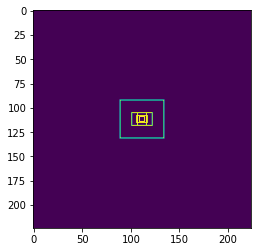

In [0]:
plot_anchorboxes(anchors)

#DataLoader

In [0]:
class dataloader:
    def __init__(self, csv_path ,image_arr_path,anchors, grid_size = (13,13),orignal_dim = (1920,1200) ,target_dim = (224,224)):
        self.csv_path = csv_path
        self.image_arr_path = image_arr_path
        self.data = pd.read_csv(self.csv_path)
        self.grid_size = grid_size
        self.target_dim = target_dim
        self.n_anchors = anchors.shape[0]
        self.orignal_dim = orignal_dim
        self.scale = 1/max(self.orignal_dim)
        self.anchors = anchors
        self.iou_score = 0
        self.count  = 0
        self.anchor_clash = 0
        self.pad_dim = 0 if orignal_dim[1] > orignal_dim[0] else 1 
        self.processed_data =  self.data.groupby("Frame").apply(self._agger_func)
        self.images = np.load(self.image_arr_path)
        self.targets = np.array(self.processed_data.values.tolist())
        self.names = self.processed_data.index.tolist()
        
    def _agger_func(self,df):

       # answer = []
       # We will have to incorporate offset from padding the image, Here the dimention is 1200 - ver
       # 1920 hor so we will shift ver coordinates by (1920 - 1200)/2 
        output_tensor = np.zeros((self.n_anchors,self.grid_size[0], self.grid_size[1],5), dtype= np.float32)
        temp_tensor = np.zeros((self.n_anchors,self.grid_size[0], self.grid_size[1]))
        offset = abs(self.orignal_dim[0] - self.orignal_dim[1])/2
        offset = offset*self.scale
        for xmin , xmax,ymin,ymax in zip(df["xmin"], df["xmax"],df["ymin"], df["ymax"]):
            if(self.pad_dim == 0):
                hor_min = xmin*self.scale + offset
                ver_min = xmax*self.scale
                hor_max = ymin*self.scale + offset
                ver_max = ymax*self.scale
            else:
                hor_min = xmin*self.scale 
                ver_min = xmax*self.scale + offset
                hor_max = ymin*self.scale 
                ver_max = ymax*self.scale + offset

            ver_center = (ver_min + ver_max)/2
            hor_center = (hor_min + hor_max)/2
            width = (hor_max - hor_min)
            height = (ver_max - ver_min)
            
            grid_scale_x = hor_center*self.grid_size[0]
            grid_scale_y = ver_center*self.grid_size[1]

            grid_x_index = int(grid_scale_x)
            grid_y_index = int(grid_scale_y)
            ground_box = np.array([0,0, width, height]).reshape(1,-1)
            anchors_centered = np.concatenate((np.zeros((self.anchors.shape[0], 2) ) , self.anchors) , axis = 1)
            iou_ = IOU_finder(ground_box , anchors_centered)
            best_anchor = np.argmax(iou_)
            self.iou_score += max(iou_.tolist())
            self.count += 1

            # The output format is t_hor , t_ver , t_w , t_h
            output_tensor[best_anchor, grid_x_index ,grid_y_index,0] = 1
            if(temp_tensor[best_anchor, grid_x_index ,grid_y_index] == 1):
                self.anchor_clash += 1
            else:
                temp_tensor[best_anchor, grid_x_index ,grid_y_index] = 1


            output_tensor[best_anchor, grid_x_index ,grid_y_index,1] = grid_scale_x 
            output_tensor[best_anchor, grid_x_index ,grid_y_index,2] = grid_scale_y
            output_tensor[best_anchor, grid_x_index ,grid_y_index,3] = width*self.grid_size[0]
            output_tensor[best_anchor, grid_x_index ,grid_y_index,4] = height*self.grid_size[1]
        return output_tensor
    
    def image_preprocess(self,img_path):
        arr = cv2.imread(img_path)
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
        dim = max(arr.shape) 
        change_dim = -1
        if(arr.shape[0] == dim):
            change_dim = 1
        else:
            change_dim = 0
        final_img = np.zeros((dim,dim,3), dtype = np.uint8)

        change = dim - arr.shape[change_dim]
        if(change_dim):
            final_img[:,change//2:change//2 + arr.shape[change_dim],:] = arr 
        else:
            final_img[change//2:change//2 + arr.shape[change_dim],:,:] = arr

        return  np.rollaxis(cv2.resize(final_img, (self.target_dim[0],self.target_dim[1])),2)

 

    def get_batch(self, batch_size):
        L = len(self.processed_data)
        index = np.random.randint(low = 0, high = L -1, size = batch_size)
        images = self.images[index]
        targets = self.targets[index]
        
      #  image_arr = np.empty((batch_size,3,self.target_dim[0] , self.target_dim[1]))
      #  for i in range(batch_size):
      #      path = os.path.join(self.image_path, images[i])
      #      image_arr[i] = self.image_preprocess(path)
        return images, targets
   
        

    


In [0]:
dataloader_object = dataloader(path,image_array_path, anchors)

#Model

In [0]:
class Detector(nn.Module):
    def __init__(self,anchors ,grid_size = 13):
        super().__init__()
        self.res_net = torchvision.models.resnet34(pretrained=True)
    #    for p in self.res_net.parameters():
    #        p.requires_grad = False

        #change final layer
        self.n_anchors = anchors.shape[0]
        self.grid_size = grid_size
        n_inputs = self.res_net.fc.in_features
        n_output = self.n_anchors*grid_size*grid_size*5
        self.res_net.fc = nn.Linear(n_inputs,n_output)
        self.lin = nn.Linear(n_output,n_output)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid() 
        self.anchors = anchors*grid_size
        self.cells_hor = torch.zeros(13,13).to(device)
        for i in range(grid_size):
            self.cells_hor[i,:] = i

        self.cells_ver = torch.zeros(13,13).to(device)
        for i in range(grid_size):
            self.cells_ver[:,i] = i
        
    def forward(self,X):
        X = self.relu(self.res_net(X))
        X = self.lin(X)

        X = X.view(-1, self.n_anchors,self.grid_size,self.grid_size,5)

        X[:,:,:,:,0:3] = self.sig(X[:,:,:,:,0:3])
        X[:,:,:,:,1] += self.cells_hor
        X[:,:,:,:,2] += self.cells_ver
        for i in range(self.n_anchors):
            X[:,i,:,:,3] = torch.exp(X[:,i,:,:,3])*self.anchors[i][0]
            X[:,i,:,:,4] = torch.exp(X[:,i,:,:,4])*self.anchors[i][1]

        
        return X 



In [0]:
model = Detector(anchors = anchors).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


#Trainer

In [0]:
class trainer():
    def __init__(self, model ,data_object):
        self.model = model.to(device)
        self.data_object = data_object
        self.optimizer = torch.optim.Adam([x for x in list(self.model.parameters()) if x.requires_grad == True], lr=0.0001)
        self.bce =  nn.BCELoss(reduction = "none")
        
    def normalize_image(self,img):

        img = img/255
        batch = torch.empty_like(img)
        Norm = transforms.Normalize(mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        for i in range(img.size()[0]):
            batch[i] = Norm(img[i])

        return batch

    def loss(self,target, prediction):

        localisation_error = 0
        detection_error = 0

        lambda_bigger = 15
        lambda_smaller = 0.1

        mask = (target[:, :, :, :, 0] == 1)
        revmask = ~mask

        error_x = ((((target[:, :, :, :, 1] - prediction[:, :, :, :, 1])**2)[mask]).sum())
        error_y = ((((target[:, :, :, :, 2] - prediction[:, :, :, :, 2])**2)[mask]).sum())

        error_w = (((    torch.sqrt(target[:, :, :, :, 3]) - torch.sqrt(prediction[:, :, :, :, 3])  )**2)[mask]).sum()
        error_h = (((    torch.sqrt(target[:, :, :, :, 4]) - torch.sqrt(prediction[:, :, :, :, 4])  )**2)[mask]).sum()

        localisation_error = lambda_bigger * (error_x + error_y + error_w + error_h)
        pred_error = self.bce(prediction[:, :, :, :, 0],target[:, :, :, :, 0])

        correct_pred_error = pred_error[mask].sum()
        incorrect_pred_error = pred_error[revmask].sum() 

        detection_error = (lambda_bigger)*correct_pred_error + lambda_smaller * incorrect_pred_error

        total_error = detection_error + localisation_error

        return total_error/target.shape[0]

    def train(self,epochs, batch_size, offset = 0):
        loss_arr = []
        for epoch in range(epochs):
            total_loss = 0
            repeat = self.data_object.count//batch_size
            for i in range(repeat):
                imgs , targets = self.data_object.get_batch(batch_size)
                imgs = torch.tensor(imgs).float().to(device)
                targets = torch.tensor(targets).float().to(device)
            
                imgs = self.normalize_image(imgs)
                output = self.model(imgs)
                output = output.view(targets.size(0),targets.size(1), targets.size(2), targets.size(3), targets.size(4))
                loss = self.loss(targets, output)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            total_loss = total_loss/repeat
            loss_arr.append(total_loss)
            if((epoch + offset )%2 == 0):
                print("Model saved")
                torch.save(model.state_dict(), os.path.join(models_path+"/swadesh_models" , "/swadesh_model" + str(epoch+offset) + str(round(total_loss, 2)) + ".pt"))
            print(epoch,total_loss)
        return model ,loss_arr


In [0]:
T = trainer(model, dataloader_object)

NameError: ignored

#Training the Model

In [0]:
model, loss_arr = T.train(epochs = 100,batch_size = 64)

Model saved
0 13.30948195448989
1 9.085041776643553
Model saved
2 6.916059958998305
3 5.595071444926423
Model saved
4 4.539192667439394
5 4.1857342309257275
Model saved
6 3.400709765630759


#Debugging - Save the Model

In [0]:
torch.save(model.state_dict(), models_path+"/swadesh_model.pt")

#Inverse YOLO


In [0]:
def inverse_yolo(prediction, target, images, anchors):

  span = 224/13
  
  
  batchsize = target.shape[0]
  gridsize = target.shape[1]
  no_of_anchors = anchors.shape[0]

  maxanchor = torch.zeros((batchsize, gridsize, gridsize), dtype = torch.uint8) 

  for b in range(batchsize):
    for g1 in range(gridsize):
      for g2 in range(gridsize):
        maxanchor[b, g1, g2] = torch.argmax(targets[b, :, g1, g2, 0])

  


  for b in range(batchsize):
    image = images[b]
    # print(image.shape)
    # image = cv2.UMat(image.cpu().numpy()).get()
    image = np.rollaxis(image, 2)
    image = np.rollaxis(image, 2)

    # image = np.ascontiguousarray(image)

    for g1 in range(gridsize):
      for g2 in range(gridsize):
        
        for a in range(no_of_anchors):
          # print(predicted[b, a, g1, g2, 1], predicted[b, a, g1, g2, 2],predicted[b, a, g1, g2, 3], predicted[b, a, g1, g2, 4])



          target[b, a, g1, g2, 1] = (target[b, a, g1, g2, 1]*span) + g1*span
          prediction[b, a, g1, g2, 1] = (span*prediction[b, a, g1, g2, 1]) +g1*span

          target[b, a, g1, g2, 2] = (span*target[b, a, g1, g2, 2]) + g2*span
          prediction[b, a, g1, g2, 2] = (span*prediction[b, a, g1, g2, 2]) +g2*span

          target[b, a, g1, g2, 3] = (torch.exp(target[b, a, g1, g2, 3]))*(anchors[a, 0])*224
          prediction[b, a, g1, g2, 3] = (torch.exp(prediction[b, a, g1, g2, 3]))*(anchors[a, 0])*224
          
          target[b, a, g1, g2, 4] = torch.exp(target[b, a, g1, g2, 4])*(anchors[a, 1])*224
          prediction[b, a, g1, g2, 4] = (torch.exp(prediction[b, a, g1, g2, 4]))*(anchors[a, 1])*224

          # print(prediction[b, a, g1, g2, 4], prediction[b, a, g1, g2, 4], )

          if prediction[b, a, g1, g2, 0] >=0.75 and prediction[b, a, g1, g2, 4]<400 and prediction[b, a, g1, g2, 2]<400and prediction[b, a, g1, g2, 1]<400 and prediction[b, a, g1, g2, 3]<400:

            xmin = int(predicted[b, a, g1, g2, 1]-predicted[b, a, g1, g2, 3]/2)
            xmax = int(predicted[b, a, g1, g2, 1]+predicted[b, a, g1, g2, 3]/2)
            ymin = int(predicted[b, a, g1, g2, 2]-predicted[b, a, g1, g2, 4]/2)
            ymax = int(predicted[b, a, g1, g2, 2]+predicted[b, a, g1, g2, 4]/2)

            # print(xmin, xmax, ymin, ymax)

            # image = np.array(image)

            
            # print(xmin, xmax, ymin, ymax)
            # print(predicted[b, a, g1, g2, 1], predicted[b, a, g1, g2, 2],predicted[b, a, g1, g2, 3], predicted[b, a, g1, g2, 4])

            image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
            
            if(type(image)==cv2.UMat):
              image = image.get()

          if target[b, g1, g2, a, 0] >0.5:

            xmin = target[b, a, g1, g2, 1]-target[b, a, g1, g2, 3]/2
            xmax = target[b, a, g1, g2, 1]+target[b, a, g1, g2, 3]/2
            ymin = target[b, a, g1, g2, 2]-target[b, a, g1, g2, 4]/2
            ymax = target[b, a, g1, g2, 2]+target[b, a, g1, g2, 4]/2

            # image = np.array(image)

            
            # print(xmin, xmax, ymin, ymax)

            image = cv2.rectangle(image, ((int(xmin), int(ymin))), (int(xmax), int(ymax)), (0, 0, 255), 3)
            print(target[b, a, g1, g2, 1], target[b, a, g1, g2, 2], target[b, a, g1, g2, 3], target[b, a, g1, g2, 4])
            
            if(type(image)==cv2.UMat):
              image = image.get()



    plt.figure(figsize=(15,9))
    plt.imshow(image)


  return prediction

#Load Model

In [0]:

model2=Detector(anchors = anchors).to(device)
model2.load_state_dict(torch.load(models_path+"/rushi_model57.pt"))
model2.eval()

#Debugging - Analyse Model

In [0]:
images, targets = dataloader_object.get_batch(1)
anchors = np.load(anchors_path)
targets = torch.from_numpy(targets).float().to(device)

In [0]:

images_t = torch.tensor(images).float().to(device)

predicted = model2(images_t)


predicted = predicted.view(targets.shape[0],targets.shape[1], targets.shape[2], targets.shape[3], targets.shape[4])
# anchors = np.load(anchors_path)
inverse_yolo(predicted, targets, images, anchors)


In [0]:
targets[targets[:, :, :, :, 0]==1]

tensor([[ 1.0000,  0.1187,  0.3578, -0.3255, -0.1085],
        [ 1.0000,  0.8656,  0.3070, -0.2041, -0.0199],
        [ 1.0000,  0.3388,  0.3206, -0.2788,  0.1699]], device='cuda:0')

#Analyze Model

In [0]:
class Tester:
    def __init__(self, model, data_object, anchors, image_dim =(224,224) , grids = 13):
        self.model = model
        self.data_object = data_object
        self.anchors = anchors
        self.grids = grids
        self.image_dim=  image_dim
        self.hor_span = self.image_dim[0]/grids
        self.ver_span = self.image_dim[1]/grids
        


    def _convert_yolo_to_real(self,t_hor,t_ver,t_width,t_height):
        hor_center_pos = t_hor/self.grids*self.image_dim[0]
        ver_center_pos = t_ver/self.grids*self.image_dim[1]
        width = t_width/self.grids*self.image_dim[0]
        height  = t_height/self.grids*self.image_dim[1]

        return [hor_center_pos, ver_center_pos , width , height]

    def normalize_image(self,img):
        img = torch.tensor(img).float().to(device)
        img = img/255
        Norm = transforms.Normalize(mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

        return Norm(img)

    def soft_NMS(self,prediction_tensor, basic_thres = .5, image_dim = 224, grids = 13 , sigma = .6 ,thresh = .001):
        predictions = prediction_tensor[prediction_tensor[:,:,:,:,0] > basic_thres]
        boxes = torch.empty_like(predictions[:,1:])
        confidence = predictions[:,0]
        N = confidence.size(0)
        indexes = torch.arange(0, N).float().to(device).view(N, 1)
        boxes[:,0] = predictions[:,1] - predictions[:,3]/2
        boxes[:,1] = predictions[:,2] - predictions[:,4]/2
        boxes[:,2] = predictions[:,1] + predictions[:,3]/2
        boxes[:,3] = predictions[:,2] + predictions[:,4]/2
        boxes = torch.cat((boxes,indexes), dim = 1)
        
        hor1 = boxes[:,0]
        ver1 = boxes[:,1]
        hor2 = boxes[:,2]
        ver2 = boxes[:,3]

        areas = (hor2 - hor1)*(ver2 - ver1)
        scores = confidence.clone()
        for i in range(N):
            tscore = scores[i].clone()
            pos = i + 1

            if(i != N-1):
                maxscore, maxpos = torch.max(scores[pos:]) , torch.argmax(scores[pos:])

                if(tscore < maxscore):
                    boxes[i], boxes[maxpos.item() + i + 1] = boxes[maxpos.item() + i + 1].clone(), boxes[i].clone()
                    scores[i], scores[maxpos.item() + i + 1] = scores[maxpos.item() + i + 1].clone(), scores[i].clone()
                    areas[i], areas[maxpos + i + 1] = areas[maxpos + i + 1].clone(), areas[i].clone()
                    confidence[i], confidence[maxpos + i + 1] = confidence[maxpos + i + 1].clone(), confidence[i].clone()


            hor1 = torch.max(boxes[i, 0], boxes[pos:, 0])
            ver1 = torch.max(boxes[i, 1], boxes[pos:, 1])
            hor2 = torch.min(boxes[i, 2], boxes[pos:, 2])
            ver2 = torch.min(boxes[i, 3], boxes[pos:, 3])
            
            w = torch.max(torch.tensor([0]).float().to(device), hor2 - hor1 + 1)
            h = torch.max(torch.tensor([0]).float().to(device), ver2 - ver1 + 1)
            inter = w * h
            ovr = torch.div(inter, (areas[i] + areas[pos:] - inter))

            weight = torch.exp(-(ovr * ovr) / sigma)
            scores[pos:] = weight * scores[pos:]

        keep = scores > thresh
        return ((boxes[keep])[:,0:4]*(image_dim)/grids).int().to("cpu").numpy().tolist() , confidence[keep].to("cpu").numpy().tolist()


    def plot_vector(self ,vector, thresh = .4, image = None):
        bboxes = []
        for anchor_box in range(vector.size(0)):
            for hor_index in range(vector.size(1)):
                for ver_index in range(vector.size(1)):
                    if(vector[anchor_box][hor_index][ver_index][0] > thresh):
                        t_hor = vector[anchor_box][hor_index][ver_index][1]
                        t_ver = vector[anchor_box][hor_index][ver_index][2]
                        t_width = vector[anchor_box][hor_index][ver_index][3]
                        t_height = vector[anchor_box][hor_index][ver_index][4]
                        bboxes.append(self._convert_yolo_to_real(t_hor, t_ver , t_width, t_height))
        

        if(image is None):
            image = np.zeros((self.image_dim[0],self.image_dim[1]),dtype = np.uint8)
        else:
            image = np.rollaxis(image,2)
            image = np.rollaxis(image,2)
        for bbox in bboxes:
            start_point = (int(bbox[0] - bbox[2]/2),  int(bbox[1] - bbox[3]/2))
            end_point = (int(bbox[0] + bbox[2]/2),  int(bbox[1] + bbox[3]/2))
            image = cv2.rectangle(image, start_point, end_point, (255, 0, 0))
        if(image is not None and bboxes != []):
            plt.imshow(image.get())
        else:
            plt.imshow(image)

        plt.show()




    def score_output(self, output , target, thres = .5,image = None):
        bboxes, _ = self.soft_NMS(output , thresh = thres)
        if(image is None):
            image = np.zeros((self.image_dim[0],self.image_dim[1]),dtype = np.uint8)
        else:
            image = np.rollaxis(image,2)
            image = np.rollaxis(image,2)
        for bbox in bboxes:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image = cv2.rectangle(image, start_point, end_point, (255, 0, 0))
        if(image is not None and bboxes != []):
            plt.imshow(image.get())
        else:
            plt.imshow(image)

        plt.show()

       
      #  return output

    def produce_output(self, img):
        img = self.normalize_image(img).unsqueeze(0)
        with torch.no_grad():
            out = self.model(img)
        return self.soft_NMS(out)











        

        




In [0]:
tester_object = Tester(model2, None, anchors)

NameError: ignored

In [0]:
recall, precision, fscore = tester_object.score_outputs(model2, dataloader_object, confthres = 0.65, thres = .5)

TypeError: ignored

#Debugging - CV2.rectangle

<class 'int'>


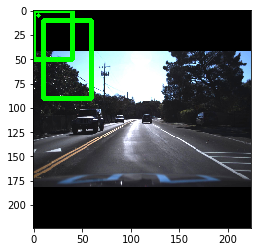

In [0]:
image = images[0]
image = np.rollaxis(image, 2)
image = np.rollaxis(image, 2)

a=0
b=0
c=40
d=50

print(type(a))

image = cv2.rectangle(image, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 3)

if(type(image)==cv2.UMat):
  image = image.get()

image = cv2.rectangle(image, ((int(10), int(10))), (int(60), int(90)), (0, 255, 0), 3)

if(type(image)==cv2.UMat):
  image = image.get()

image = cv2.rectangle(image, ((int(5.4), int(5.8))), (int(5), int(5)), (0, 255, 0), 3)
# image = image.get()
if(type(image)==cv2.UMat):
  image = image.get()

plt.imshow(image)

#Storing the resullt

In [0]:
def store(dataloader, folder_path):
    for index,img in zip(dataloader_object.names ,  dataloader_object.images):
        pth = os.path.join(folder_path,index + "_swad.txt")
        with open(pth, "a") as handle:
            data = Test.produce_output(img)
            for box, conf in zip(data[0], data[1]):
                press_list = []
                press_list.append("car")
                press_list.append(str(conf) )
                box = [str(x) for x in box]
                press_list += box
                handle.write(" ".join(press_list))
                handle.write("\n") 

In [0]:
# store(dataloader_object, folder_path)

KeyboardInterrupt: ignored

#Task

In [0]:
  # Finish the following functions

def NMS(model_output , basic_thres , NMS_thres, span):

    no_of_grids = model_output.size(2)
    no_of_anchors = model_output.size(1)

    predictions = model_output[prediction_tensor[:,:,:,:,0] > basic_thres]
    boxes = torch.empty_like(predictions[:,1:])
    confidence = predictions[:,0]
    N = confidence.size(0)
    indexes = torch.arange(0, N).float().to(device).view(N, 1)
    boxes[:,0] = predictions[:,1] - predictions[:,3]/2
    boxes[:,1] = predictions[:,2] - predictions[:,4]/2
    boxes[:,2] = predictions[:,1] + predictions[:,3]/2
    boxes[:,3] = predictions[:,2] + predictions[:,4]/2
    # boxes = torch.cat((boxes,indexes), dim = 1)
    
    hor1 = boxes[:,0]
    ver1 = boxes[:,1]
    hor2 = boxes[:,2]
    ver2 = boxes[:,3]

    areas = (hor2 - hor1)*(ver2 - ver1)
    for i in range(N):
        tscore = scores[i].clone()
        pos = i + 1

        if(i != N-1):
            maxscore, maxpos = torch.max(scores[pos:]) , torch.argmax(scores[pos:])

            if(tscore < maxscore):
                boxes[i], boxes[maxpos.item() + i + 1] = boxes[maxpos.item() + i + 1].clone(), boxes[i].clone()
                areas[i], areas[maxpos + i + 1] = areas[maxpos + i + 1].clone(), areas[i].clone()
                confidence[i], confidence[maxpos + i + 1] = confidence[maxpos + i + 1].clone(), confidence[i].clone()


        hor1 = torch.max(boxes[i, 0], boxes[pos:, 0])
        ver1 = torch.max(boxes[i, 1], boxes[pos:, 1])
        hor2 = torch.min(boxes[i, 2], boxes[pos:, 2])
        ver2 = torch.min(boxes[i, 3], boxes[pos:, 3])
        
        w = torch.max(torch.tensor([0]).float().to(device), hor2 - hor1 + 1)
        h = torch.max(torch.tensor([0]).float().to(device), ver2 - ver1 + 1)
        inter = w * h
        ovr = torch.div(inter, (areas[i] + areas[pos:] - inter))

        boxes = boxes[ovr>NMS_thres]

    keep = scores > thresh
    boxes = boxes*span
    return ((boxes[keep])[:,0:3]*(image_dim)/grids).int().to("cpu").numpy().tolist() , confidence[keep].to("cpu").numpy().tolist()


  """
  This function does the following
  1) remove all the prediction bellow the basic_thresh ie .2 or .3
  3) Run nms algo on model_output which is basically a (1,5,13,13,5) pytorch tensor
  notice that the last 5 dimention stores the following
  (confidence , t_hor , t_ver , t_width , t_height)
  Both centers are absolute with respect to grids ie a valur of 5.6 will mean 5th grid + .6
  To convert the centers into image dimentions just multiply with the span.
  Both width and height are with respect to grid size 
  The following code will convert into image dimention

    hor_center_pos = t_hor/grids*image_dim[0]
    ver_center_pos = t_ver/grids*image_dim[1]
    width = (t_width/grids)*image_dim[0]
    height  = (t_height/grids)*image_dim[1]

    where image_dim = [224,224] and grids = 13


    this is to be converted into left most and right most corner form in the end and all the NMS outputs are returned as a list


  """


def find_objects(model , image, basic_thres = 0.3, nms_thres = 0.5, span = 1920/13):

  image = image.unsqueeze(0)

  image = image/255
  image = torch.tensor(image)
  Norm = transforms.Normalize(mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  image2 = Norm(image)
  image2

  with torch.no_grad():
    output = model(image)

  return NMS(output, basic_thres, nms_thres, span)

  

  
    
  

    """
    This function takes as input a pytorch model and image(as an np array), processes image and feed it to the model.
    (use normalize function from Trainer object or create a new function) 
    After getting the output, use NSM function (look at its defination to know more)

    This function returns a list of predictions


    """


"""
IMPORTANT

   dataloader object has 3 variables called 
   1) Images
   2) Targets
   3) names
   They are all the images and targets !!!

   dataloader_object.Images is a (9000 , 3, 224 ,224) np-array for uint8 all processed
   daloader_object.targets are corrosponding targets in np_array ie (9000,5,13,13,5)
   dataloader_object.names are the names of corrosponding images ie a list of len 9000
   note that we have 9000- something images so 9000 is not an exact number, its just so that you dumb bitches dont get confused!!!



"""

def make_dict(images, dataloader_object):



"""
Now use these functions and you own brains to do the following 

1) Feed the images one by one to a given model
2) make a dictionary that has names of all the images as keys and list of prediction as values


Once more cause yall soooo fucking dumb
A DICTIONARY

image_name.jpg  ----->  [ [predicted_box 1] , ........        [predicted_box n]        ]

where  [predicted_box i] are 4 int values representing [ left ,top ,  right , bottom  ]

Once more cause again you faggots are the dumbest shit to ever dwell planet earth


    0,0 ------> x (width)
     |
     |  (Left,Top)
     |      *_________
     |      |         |
            |         |
     y      |_________|
  (height)            *
                (Right,Bottom)




"""